In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
!pip install tensorflow-gpu==2.0.0-beta

     |████████████████████████████████| 348.9MB 50kB/s 
     |████████████████████████████████| 3.1MB 40.7MB/s 
     |████████████████████████████████| 501kB 46.5MB/s 


In [3]:
!pip install imageio

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.layers import Input

from IPython import display
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
(train_images,train_labels),(_, _)= tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
  train_images.shape
  

(60000, 28, 28)

In [6]:
  train_labels.shape

(60000,)

In [0]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')

In [8]:
train_images.shape

(60000, 28, 28, 1)

In [0]:
#normalize the images to [-1,1]
train_images= (train_images-127.5)/127.5

In [0]:
BUFFER_SIZE=60000
BATCH_SIZE =256

In [0]:
#batch and shuffle the data
train_dataset= tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Visualize dataset

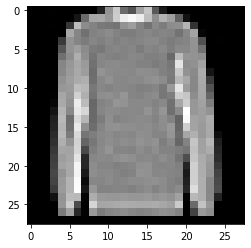

In [12]:
plt.imshow(train_images[45].reshape((28,28)) , cmap='gray')

The generator function


In [0]:
def make_generator_model():
  model= tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) #1254400
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Reshape((7,7,256)))
  
  model.add(layers.Conv2DTranspose(128,  (5,5), strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(64,  (5,5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(1,  (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  model.summary()
  
  return model

In [14]:
generator=make_generator_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [15]:
#generate an image from a random noise seed.
# the noise is an array of 100 random images 

noise =tf.random.normal([1,100])
generated_image= generator(noise,training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

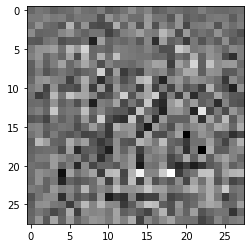

In [16]:
plt.imshow(generated_image[0,:,:,0], cmap='gray')

Build the discriminator

In [0]:
def make_discriminator_model():
  model= tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(128,(5,5),strides=(2,2), padding='same')) 
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
            
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  model.summary()
            
  return model

In [18]:
discriminator=make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [19]:
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.00084104]], shape=(1, 1), dtype=float32)


Define the loss function for both networks

In [0]:
#difference between the model predictions and the true label
cross_entropy= tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss= cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss= cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss= real_loss + fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer= tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer= tf.keras.optimizers.Adam(1e-4)

In [0]:
#tracking the training
checkpoint_dir='./training_checkpoints'
checkpoint_prefix= os.path.join(checkpoint_dir,"ckpt")
checkpoint= tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               generator=generator,
                               discriminator=discriminator)

In [0]:
#train the model
EPOCHS=100
noise_dim=100
num_examples_to_generate=16

seed= tf.random.normal([num_examples_to_generate,noise_dim])

In [0]:
@tf.function
def train_step(images):
  noise= tf.random.normal([BATCH_SIZE,noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True) #step1 call the generator and feed in the noise
    
    real_output= discriminator(images,training=True) # step2 pass the fake and real ones to the discriminator
    fake_output= discriminator(generated_images,training=True)
    
    gen_loss= generator_loss(fake_output)# step3 calculatethe loss for both the generator and the discriminator
    disc_loss= discriminator_loss(real_output, fake_output)
    
    gradients_of_generator= gen_tape.gradient(gen_loss, generator.trainable_variables) #step4   calculate the gradient of the losses
    gradients_of_discriminator= disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) #step 5 apply the optimizers and update weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Training

In [0]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start=time.clock()
    
    for image_batch in dataset:
      train_step(image_batch)
      
     # produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch +1, seed)
    
    # save the model every 15 epochs
    if (epoch +1) % 15 ==0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Time for epoch {} is {} sec'.format(epoch +1, time.clock()-start))
    
  #generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epoch, seed)

In [0]:
def generate_and_save_images(model, epoch,test_input):
  predictions= model(test_input, training=False)
  
  fig= plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+ 127.5, cmap='gray')
    plt.axis('off')
    
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

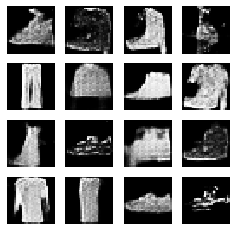

CPU times: user 9min 12s, sys: 1min 55s, total: 11min 7s
Wall time: 43min 7s


In [29]:
%%time
train(train_dataset, EPOCHS)

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


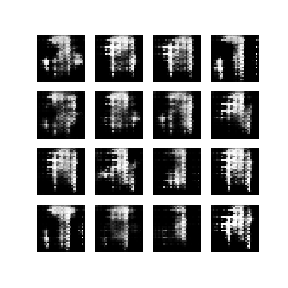

In [31]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(8)